In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from xgboost import XGBClassifier

In [2]:
tqdm.pandas()

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')

In [5]:
df = df.dropna()

In [6]:
df.sample(5)

,id,qid1,qid2,question1,question2,is_duplicate
317534,317534,64271,67694,Which is the best laptop under Rs 25000?,Which are the best laptops under INR 25000 in ...,1
226014,226014,334522,334523,How do I decide whether a quantity will be con...,Y axis and x axis must have different graduati...,0
336879,336879,464285,464286,Which colors match pink?,What are the best colors to contrast pink?,0
17197,17197,32713,32714,What is difference between conducting and non-...,Why does a base conduct electricity?,0
258363,258363,373909,373910,What are some great places to go mushroom hunt...,Are mushrooms vegetables?,0


In [7]:
df.shape

(404287, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [9]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [10]:
df.duplicated().sum()

0

63.08% of the questions are unique


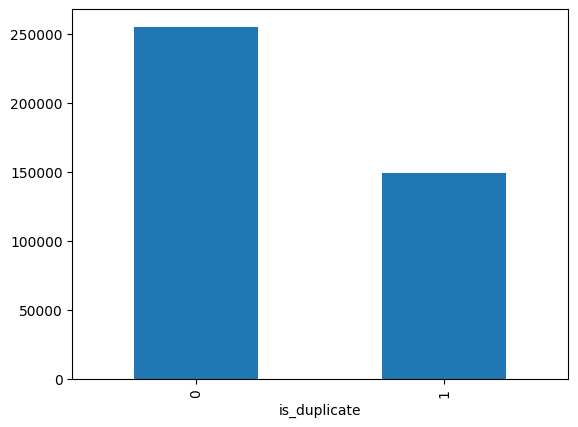

In [11]:
df['is_duplicate'].value_counts().plot(kind = 'bar')
print(f"{df[df['is_duplicate'] == 0].shape[0] / df.shape[0] *100:.2f}% of the questions are unique")

In [12]:
total_question = (pd.concat([df['qid1'], df['qid2']], axis=0).reset_index(drop=True))
print(f"Number of unique questions {total_question.nunique()}")
x = total_question.value_counts() > 1
print(f"Number of questions that were repeated {x[x].shape[0]}")

Number of unique questions 537929
Number of questions that were repeated 111778


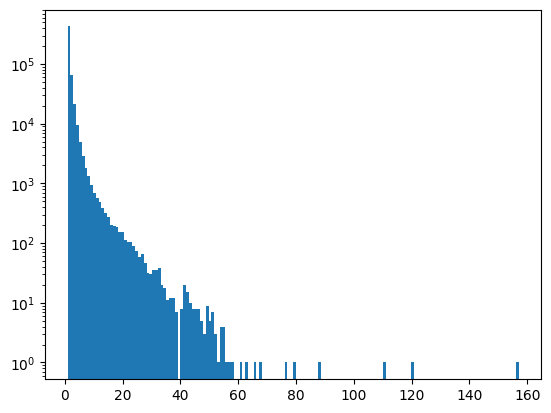

In [13]:
plt.hist(total_question.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

In [14]:
df = df.sample(frac = 0.1)

In [15]:
stopwords_set = set(stopwords.words('english'))
emoji_pattern = re.compile('(?::|;|=)(?:-)?(?:\)|\(|D|P)')

def preprocessing(text):
    # Check if text is a string or bytes-like object
    if not isinstance(text, (str, bytes)):
        return ""  # Return empty string if text is not a string or bytes-like object

    global i
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    
    # Find emojis
    emojis = emoji_pattern.findall(text)
    
    # Remove non-word characters, convert to lowercase, and join emojis
    text = re.sub('[\W+]', ' ', text.lower()) + ' '.join(emojis).replace('-', '')

    # Stemming and removing stopwords
    prter = PorterStemmer()
    text = [prter.stem(word) for word in text.split() if word not in stopwords_set]

    return " ".join(text)


In [16]:
df['question1'] = df['question1'].progress_apply(lambda x: preprocessing(x))
df['question2'] = df['question2'].progress_apply(lambda x: preprocessing(x))

100%|██████████| 40429/40429 [00:10<00:00, 3933.86it/s]


In [17]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
257592,257592,316192,372945,hardest thing get use come franc,hardest thing get use come singapor,0
340363,340363,405755,468074,draft mail hr ask interview statu,question ask futur hr career interview,0
264248,264248,380982,380983,north american univers best ux ui design gradu...,best univers learn ux usa,0
396265,396265,89165,529314,u marin insist separ branch arm forc u form pa...,worst discrimin receiv veteran u arm forc incl...,0
259032,259032,74400,213898,hack whatsapp account listen voic messag,hack whatsapp remot,1


In [18]:
y = df['is_duplicate']

In [19]:
total_question = pd.concat([df['question1'], df['question2']], axis=0)

In [20]:
cv = CountVectorizer(max_features = 5000)
cv.fit(total_question)

CountVectorizer(max_features=5000)

In [21]:
q1 = cv.transform(df['question1']).toarray()
q2 = cv.transform(df['question2']).toarray()

In [22]:
combined_data = np.hstack((q1, q2))

In [23]:
df1 = pd.DataFrame(combined_data)

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df1,y, test_size = 0.2, random_state = 42)

In [25]:
rf = RandomForestClassifier(n_estimators = 10)

rf.fit(x_train, y_train)

print(accuracy_score(rf.predict(x_test), y_test))

0.7149394014345782


In [26]:
xg = XGBClassifier()

xg.fit(x_train, y_train)

print(accuracy_score(xg.predict(x_test), y_test))

0.7186495176848875


In [27]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
257592,257592,316192,372945,hardest thing get use come franc,hardest thing get use come singapor,0
340363,340363,405755,468074,draft mail hr ask interview statu,question ask futur hr career interview,0
264248,264248,380982,380983,north american univers best ux ui design gradu...,best univers learn ux usa,0
396265,396265,89165,529314,u marin insist separ branch arm forc u form pa...,worst discrimin receiv veteran u arm forc incl...,0
259032,259032,74400,213898,hack whatsapp account listen voic messag,hack whatsapp remot,1


In [28]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [29]:
def number_of_words(text):
    return len(text.split(" "))
    

In [30]:
df['q1_words'] = df['question1'].progress_apply(lambda x: number_of_words(x))
df['q2_words'] = df['question2'].progress_apply(lambda x: number_of_words(x))

100%|██████████| 40429/40429 [00:00<00:00, 303565.74it/s]


In [31]:
def number_of_common_words(row):
    x = set(row["question1"].split()) & set(row["question2"].split())
    return len(x)

In [32]:
df['common_words_count'] = df.progress_apply(number_of_common_words, axis=1)

100%|██████████| 40429/40429 [00:00<00:00, 40429.17it/s]


In [33]:
def number_of_total_words(row):
    x = set(row["question1"].split()) | set(row["question2"].split())
    return len(x)

In [34]:
df['total_words'] = df.progress_apply(number_of_total_words, axis=1)

100%|██████████| 40429/40429 [00:01<00:00, 40117.54it/s]


In [35]:
df['share_word'] = round(df['common_words_count'] / (df['total_words'] + 0.0001), 2)

In [36]:
df1['q1_len'] = np.array(df['q1_len'])
df1['q2_len'] = np.array(df['q2_len'])
df1['q1_words'] = np.array(df['q1_words'])
df1['q2_words'] = np.array(df['q2_words'])
df1['common_words_count'] = np.array(df['common_words_count'])
df1['total_words'] = np.array(df['total_words'])
df1['share_word'] = np.array(df['share_word'])

In [37]:
df1.columns = df1.columns.astype(str)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(df1, y, test_size = 0.2, random_state = 42)

In [39]:
rf = RandomForestClassifier(n_estimators = 10)

rf.fit(x_train, y_train)

print(accuracy_score(rf.predict(x_test), y_test))

0.756740044521395


In [40]:
xg = XGBClassifier()

xg.fit(x_train, y_train)

print(accuracy_score(xg.predict(x_test), y_test))

0.7626762305218897
